In [165]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import (
    PolynomialFeatures, 
    OneHotEncoder,
    SplineTransformer
)

In [5]:
df = pd.read_csv('data/Wage.csv')
df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [20]:
x = df['age']
y = df['wage']

In [50]:
def poly(x, p): 
    # transform to poly of degree p
    x = np.array(x)
    X = np.hstack((x**k for k in range(p + 1)))
    return np.linalg.qr(X)[0][:, 1:]

polynomial_features = PolynomialFeatures(degree=4)
x = np.array(x).reshape((-1, 1))
xp = polynomial_features.fit_transform(x) # pure polynomial transform
# xp = poly(x, 4) # orthogonal columns, but you gotta add a constant
# xp = sm.add_constant(xp)

result = sm.OLS(y, xp).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           2.77e-57
Time:                        20:01:48   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.0

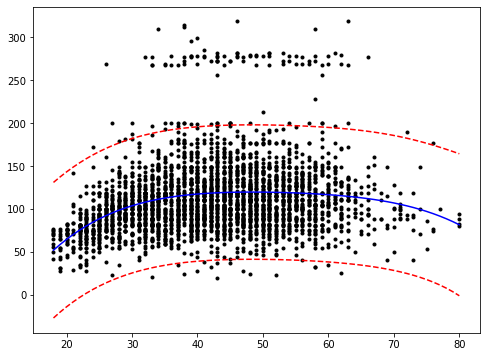

In [73]:
test_data = np.arange(x.min(), x.max() + 1).reshape(-1, 1)
test_data_p = polynomial_features.fit_transform(test_data)
pred = result.get_prediction(test_data_p)
sf = pred.summary_frame()

lower = sf['obs_ci_lower']
upper = sf['obs_ci_upper']
mean = sf['mean']

# prediction intervals are where a prediction will probably fall within a certain probability

# plot prediction intervals
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.plot(x, y, 'k.', label='Test Data')
ax.plot(test_data, mean, 'b', label='OLS')
ax.plot(test_data, lower, "r--")
ax.plot(test_data, upper, "r--")

In [74]:
# if we used orthogonal polylnomials, we could analyze p-values 
# to see whether a degree d polynomial is sufficient
# but we could also not and just do an ANOVA test

In [106]:
# naive logistic prediction, i think this worked? looks funky, but maybe
# cause this just doesn't work well, makes sense cause it's so concentrated towards the bottom
y_ind = np.apply_along_axis(lambda x: 1 if x >= 250 else 0, axis=1, arr=np.array(y).reshape((-1, 1)))
logistic_result = sm.GLM(y_ind, xp, family=sm.families.Binomial()).fit()

           mean       mean_se  mean_ci_lower  mean_ci_upper
0  9.826349e-09  6.037272e-08   5.789509e-14       0.001665
1  7.577793e-08  3.984230e-07   2.535830e-12       0.002259
2  4.746672e-07  2.120648e-06   7.473355e-11       0.003006
3  2.449189e-06  9.225813e-06   1.522781e-09       0.003924
4  1.055184e-05  3.322775e-05   2.202266e-08       0.005030


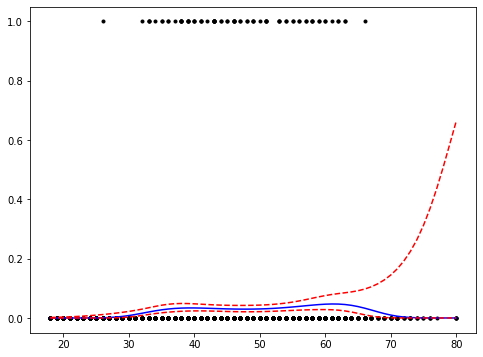

In [185]:
logistic_pred = logistic_result.get_prediction(test_data_p)
logistic_sf = logistic_pred.summary_frame()
print(logistic_sf.head())

logistic_lower = logistic_sf['mean_ci_lower'] # i'm pretty sure this is wrong, we probably have to manually compute this
logistic_upper = logistic_sf['mean_ci_upper']
logistic_mean = logistic_sf['mean']

# prediction intervals are where a prediction will probably fall within a certain probability

# plot prediction intervals
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.plot(x, y_ind, 'k.', label='Test Data')
ax.plot(test_data, logistic_mean, 'b', label='OLS')
ax.plot(test_data, logistic_lower, "r--")
ax.plot(test_data, logistic_upper, "r--")

In [186]:
# stepwise
categorized = pd.cut(x.reshape((-1,)), bins=4, labels=False)
categorized = categorized.reshape((-1, 1))
enc = OneHotEncoder().fit(categorized)
encoded = enc.transform(categorized).toarray()
encoded = sm.add_constant(encoded).astype(np.int32)
step_res = sm.OLS(y, encoded).fit()
step_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.58
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           1.13e-41
Time:                        21:13:00   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.3984      1.061     81.435      0.000      84.318      88.479
x1             7.7599      1.560      4.975      0.000       4.702      10.818
x2            31.8134      1.351     23.540      0.000      29.164      34.463
x3            31.4245      1.544     20.352      0.000      28.397      34.452
x4            15.4005      3.840      4.011      0.000       7.872      22.929
==============================================================================
Omnibus:                     1062.354   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4551.200
Skew:                           1.681   Prob(JB):                         0.00
Kurtosis:                       8.011   Cond. No.                     1.78e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.29e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [223]:
# splines, i'm confused why we have one less basis function here tho :/
# currently this is a natural spline
transformer = SplineTransformer( 
    degree=3, 
    knots=np.array([25, 40, 60]).reshape((-1, 1)),
    include_bias=True,
    extrapolation='linear' # change this to continue to get a non natural spline
)
spline_x = transformer.fit_transform(x)
spline_res = sm.OLS(y, spline_x).fit()
spline_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     70.05
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           8.80e-57
Time:                        21:46:20   Log-Likelihood:                -15316.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -5.5650     18.153     -0.307      0.759     -41.159      30.029
x2           101.9815      5.389     18.925      0.000      91.416     112.547
x3           122.7199      4.085     30.045      0.000     114.711     130.729
x4           118.8394      5.941     20.004      0.000     107.191     130.488
x5            92.7963     16.761      5.536      0.000      59.932     125.661
==============================================================================
Omnibus:                     1098.734   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4979.702
Skew:                           1.723   Prob(JB):                         0.00
Kurtosis:                       8.288   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  57.718601  4.556010      48.785375      66.651827    -21.082953   
1  61.925636  4.050445      53.983700      69.867572    -16.769705   
2  66.132671  3.557229      59.157812      73.107530    -12.470961   
3  70.339706  3.082295      64.296077      76.383336     -8.186772   
4  74.546742  2.635546      69.379078      79.714405     -3.917181   

   obs_ci_upper  
0    136.520155  
1    140.620977  
2    144.736304  
3    148.866185  
4    153.010664  


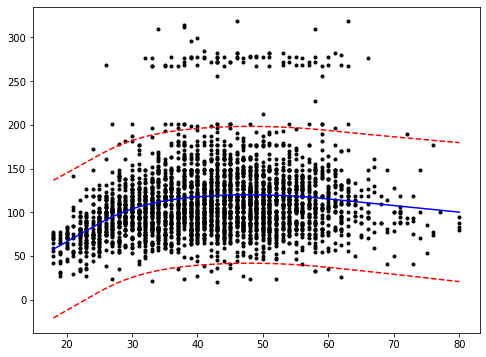

In [224]:
spline_pred = spline_res.get_prediction(transformer.transform(test_data))
spline_sf = spline_pred.summary_frame()
print(spline_sf.head())

spline_lower = spline_sf['obs_ci_lower']
spline_upper = spline_sf['obs_ci_upper']
spline_mean = spline_sf['mean']

# prediction intervals are where a prediction will probably fall within a certain probability

# plot prediction intervals
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.plot(x, y, 'k.', label='Test Data')
ax.plot(test_data, spline_mean, 'b', label='OLS')
ax.plot(test_data, spline_lower, "r--")
ax.plot(test_data, spline_upper, "r--")

In [225]:
# for smoothing splines, maybe use scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html
# unfortunately idk how to actually do regression with this 
# meaning that i can only call this function and have this be my regression

In [226]:
# for GAMs, just do what we did before and mash variables together
# doesn't seem very interesting, just annoying bashing